# 小波和多分辨率处理

在傅里叶变换中，用一个正弦波函数的无穷级数去拟合一个原函数，并且由该级数得到原函数的时域与频域函数，这样的理论是优美的。但是它有一个很大的缺陷：**在傅里叶变换中，不同的时域有可能得到相同的频域**。

这和之前所说的时频转换时信息不丢失好像有点不太一样。其实是这样的：利用傅里叶变换将时域函数转变为频域函数的过程中，频域会给出时域函数包含的**频率**，但是这些频率和时间没有关系。

举一个音乐中的例子：演奏者根据乐谱演奏音乐，在乐谱上记录的是一个一个的音符，而演奏出来的则是连续的音乐。我们可以视乐谱为信号的频域，而音乐就是信号的时域。要让一段音乐具有意义，需要让音符在不同的时间进入。对于傅里叶变换来说，得到一段信号由哪些频率成分组成就像是得到一段音乐中使用了哪些音符，却丢失了这些音符演奏的次序。

用另一种方式来说，**传统的傅里叶变换是不能用来处理非平稳信号的**。可惜，自然产生的大部分信号都是非平稳的，这就使得傅里叶变换遇到了很大的局限。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

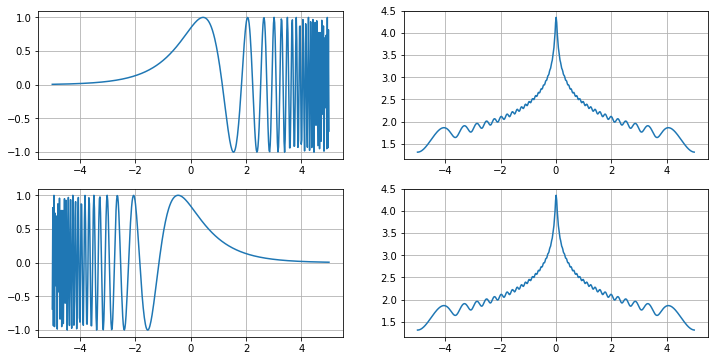

In [7]:
x = np.linspace(-5, 5, 500)
y1 = np.sin(np.exp(x))
y2 = np.sin(np.exp(-x))
plt.figure(figsize = (12, 6))
plt.subplot(221), plt.plot(x, y1), plt.grid(True)
plt.subplot(222), plt.plot(x, np.real(np.log(fftshift(fft(y1))))), plt.grid(True)
plt.subplot(223), plt.plot(x, y2), plt.grid(True)
plt.subplot(224), plt.plot(x, np.real(np.log(fftshift(fft(y2))))), plt.grid(True)
plt.show()

上面就是两个简单的非平稳信号，在第一个里面，高频部分出现的实现晚而第二个信号的高频部分出现的时间早，但是两者的傅里叶变换结果都是一致的。

为什么会出现这样的情况？为什么傅里叶变换会和频率出现的先后无关？这个问题可以这样去理解：由于组成傅里叶级数的基函数是正弦函数，这一类函数的特点就是在整个实数域上周期连续，所以由它们生成的函数也具有这样的性质。

## 小波函数

而小波不是这样的，一个**小波**只会在一段时间内持续，很快便衰减下去，这有些像吉他，拨动一根弦会发出一种频率的乐音，持续一段时间，然后音量渐渐减弱直至消失。和傅里叶级数所处的正弦函数空间一样，小波变换是在一个**小波函数**空间中的操作，至于这样的小波函数如何选取，并不是一定的，至于小波长什么样，我们来举个例子

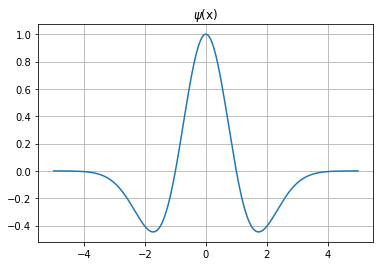

In [39]:
x = np.linspace(-5, 5, 500)
y = (1 - x ** 2) * np.exp(-x ** 2 / 2)
plt.plot(x, y), plt.grid(True), plt.title('$\psi$(x)')
plt.show()

> 上面的这个函数称为**墨西哥帽状函数**，因为它长得很像墨西哥的一种叫Sombrero的草帽
> 
> ![](Sombrero.jpg)

如何选取基函数，参数如何，这些基函数如何确定，这就是进一步的问题了

## 从傅里叶变换开始

讲到小波变换就离不开傅里叶变换，我们来回忆一下傅里叶变换的公式：

$$
F(\omega) = \int_{-\infty}^{\infty}f(t)e^{-i\omega t}dt
$$

$$
f(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty}F(\omega)e^{i\omega t}d\omega
$$

上面我们已经从感性上认识到了，这样的傅里叶变换是不能处理时间信号的。由于这种缺陷，引入**窗口化的傅里叶变换**，记作$\mathscr{F}^{win}$

$$
\mathscr{F}^{win}[f](\omega, t) = \int_{-\infty}^{\infty}f(s)g(s - t)e^{-i\omega s}ds
$$

这里的$g(s)$为窗函数，用它来乘原函数$f$就可以得到$f$中的一小段，这是很好的。但是窗函数必须满足下面的特征：

1. 中心为1，两侧衰减为0
2. 有良好的时频特性

为了符合这两点，我们通常采用高斯函数，因为高斯函数的傅里叶变换仍然是高斯函数。

这种傅里叶变换需要确定$g(s)$每次位移的单位$t_0$，每次平移一个$t_0$，然后进行局部的傅里叶变换，再平移，再变换……

设$t = nt_0, \omega = m\omega_0$，则上面的式子可以进一步写成

$$
\mathscr{F}^{win}_{m, n}[f] = \int_{-\infty}^{\infty}f(s)g(s - nt_0)e^{-im\omega_0 s}ds
$$

这就产生了另外一个问题：在选取的这个窗口$t_0$中，傅里叶变换仍然是和时间无关的，就像一首1小时的音乐，选取其中长度为1分钟的一段，然后列出这1分钟里面用到了哪些音符，这仍然是没有意义的。为了让它有意义，比如把窗口时间再缩短，缩短到每1秒用到了哪些音符，甚至更短，这样才能复原出原来的乐曲。

> 事情总是不如我们想象地那么美好，对傅里叶变换改进的企图的最后一个打击来自量子力学：**海森堡不确定性原理**告诉我们，对于一个物体，只能精确地测量位置，或者精确地测量动量，而不能二者兼顾。
>
> 把这句话翻译到傅里叶理论中，位置也就是信号的时域，动量就是信号的频域，当信号的持续时间很短的时候，我们便无法知晓它的频率成分如何，通过傅里叶变换就会得到一张散布于整个数轴的频谱；相反，当频率很集中的时候，我们也无法知道时域中的信号从何时开始，到何时结束。
>
> 之前曾经遇到过的**振铃效应**就可以利用这种理论来解释

## 小波变换与窗口化的傅里叶变换的相似与不同

小波变换是一种与窗口化傅里叶变换相类似的时频描述方法，记小波变换为$\mathscr{T}$，具体的变换表达式如下：

$$
\mathscr{T}[f](a, b) = \frac{1}{\sqrt{a}}\int_{-\infty}^{\infty}f(t)\psi(\frac{t - b}{a})dt
$$

$$
\mathscr{T}_{m, n}[f] = (\frac{1}{\sqrt{a_0}})^m\int_{-\infty}^{\infty}f(t)\psi(a_0^{-m}t - nb_0)dt
$$

观察小波变换和窗口化傅里叶变量的表达式，在积分内部都是函数$f(t)$与一个基函数做内积。在窗口化傅里叶中，这个基函数的

$$
g^{\omega, t}(s) = e^{i\omega s}g(s - t)
$$

而在小波变换中，是

$$
\psi^{a, b}(s) = \frac{1}{\sqrt{a}}\psi(\frac{s - b}{a})
$$

注意，这里前后的$\psi$代表的意义有差别：$\psi^{a, b}$表示小波变换中的基函数，而$\psi$指选定的小波函数。

通常将$\psi^{a, b}$称为**小波**，称$\psi$为**母小波**

## 从泛函的观点来看

小波分析的发展可以说是**从傅里叶抽象到函数空间**，再**从函数空间特化到小波上**的。泛函理论从数学物理方法中的变分法发展而来，是对函数空间的研究，是线性代数理论的进一步抽象。

对于傅里叶变换来说，一个一维实函数$f(x)$可以分解为在基函数集合$\{e^{-ik}\ |\ k\in \mathtt{R}\}$中的函数的线性组合，若将这个集合中的每个函数都看作一个维度的话，那么这个集合将张成一个无穷维的向量空间。而任意（可度量的、平方可积的）一维函数都可以表示为这个无穷维的向量空间中的一个点（准确地说是一个向量）

抽象地说，如果有一个基函数集合$\{\varphi_k\ |\ k\in \mathtt{R}\}$，一个任意的一维函数都可以表示为这个基函数元素的线性组合的话，它就可以作为一个和傅里叶变换等效的存在。

$$
f(x) = \sum_k \alpha_k \overline{\varphi}_k
$$

在傅里叶变换的推导中，我们知道

$$
c_n = \int_{-\infty}^{\infty}f(t)e^{-i\omega_n t}dt
$$

让我们来仔细想想，这个系数为何要这样来求：

在傅里叶变换中，所有的函数都是在$\{e^{i\omega_n} |\ n\in \mathtt{Z}\}$中的一个向量，那么求解$c_n$就是求函数$f(x)$在该函数空间中的某一个维度的坐标。那么，如何在向量空间中求解一个维度的坐标呢？我们可以在二维的欧氏空间中进行类比：

> 假如在二维的欧氏空间中，在自然标准基$[1\ 0]$和$[0\ 1]$下，有向量$[2\ 3]$，那么，在基$[\frac{1}{\sqrt{2}}\ \frac{1}{\sqrt{2}}]$和$[\frac{1}{\sqrt{2}}\ -\frac{1}{\sqrt{2}}]$下，该向量的坐标是多少？

要解决这个问题，就要将该向量对后面的新基的每一个基向量做内积，得到不同在不同基向量上的坐标。

In [5]:
v = np.matrix([[2], [3]])
base = np.matrix([[1 / np.sqrt(2), 1 / np.sqrt(2)],
                  [1 / np.sqrt(2), -1 / np.sqrt(2)]])
base.dot(v)

matrix([[ 3.53553391],
        [-0.70710678]])

In [6]:
res = base.dot(v)
base.dot(res)

matrix([[2.],
        [3.]])

可以看到，内积可以解决在不同基之间的坐标转换问题，同样的，假如一个函数空间具有向量空间的性质，那么也可以套用这样的方法：函数$f(x)$在某一维上的坐标可以表示为

$$
\alpha_k = <f(x), \overline{\varphi}_k> = \int f(x)\overline{\varphi}_k(x)dx
$$

没错，两个函数的内积就是指两个函数乘积的积分，这个积分可以在一个闭区间内，也可以在整个数域上，但是一个定积分，$a_k$一定是一个复数或实数。

就此我们可以说，对傅里叶级数理论的拓展，就是一个寻找qita函数基的过程。

### 继续傅里叶

上面的推导忽略了一个很重要的概念：对偶空间，也就是集合$\{\overline{\varphi}_k\}$。为了解释这一点，让我们继续回顾一下傅里叶级数的相关细节：

对于一个（符合Dirichlet条件）的函数$f(x)$，可以分解为无穷级数

$$
f(x) = \sum_{n = -\infty}^{\infty}c_ne^{i\omega_nt}
$$

而$c_n$可以用下面的式子计算：

$$
c_n = \int_{-\infty}^{\infty}f(t)e^{-i\omega_nt}dt = <f(t), e^{-i\omega_nt}>
$$

在这里，集合$\{e^{i\omega_nt}\}$和$\{e^{-i\omega_nt}\}$就构成了一个对偶对，前者作为基，而后者作为计算系数用的函数空间。

那么，这两个函数空间有什么联系呢？为什么要用后者计算前者空间中的系数？更进一步和细致的讨论跳到文件`从线性代数到小波变换.md`